In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from pickle import dump , load
import pandas as pd
import numpy as np
import os

In [9]:
class RiskClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(9, 16)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(16, 32)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(32, 64)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(64, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act_output(self.output(x))
        return x
    
    
def load_model(input_folder = './../model_training/credit_risk_model'):
    model = torch.load(input_folder)
    model.eval()
    return model


def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    accuracy = (y_pred.round() == y_test).float().mean()
    return accuracy

    
def create_and_train_model(X_train, y_train, X_test, y_test, num_epochs, seed):
    torch.manual_seed(seed)
    
    model = RiskClassifier()
    batch_size = 128
    loss_fn = nn.BCELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.eval()
    accuracy = evaluate(model, X_test, y_test)
    print('accuracy before training {}'.format(accuracy))
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        for i in range(0, len(X_train), batch_size):
            Xbatch = X_train[i:i+batch_size]
            y_pred = model(Xbatch)
            ybatch = y_train[i:i+batch_size]
            loss = loss_fn(y_pred, ybatch)
            # print(loss)
            loss.backward()
            optimizer.step()
        # print(loss.tolist())
        # evaluate model on each epoch
    model.eval()
    accuracy = evaluate(model, X_test, y_test)
    print(f'Finished epoch {epoch},  accuracy {accuracy}')
    return model

def replace_column_values(df, column_name, old_value, new_value):
    if column_name in df.columns:
        df[column_name] = df[column_name].replace(old_value, new_value)
        print(f"All instances of '{old_value}' in column '{column_name}' have been changed to '{new_value}'.")
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame.")
    return df


def create_data(train_df_loc, test_df_loc):
    
    train = pd.read_csv('./../train.csv')
    train.drop(['Unnamed: 0'], axis=1, inplace=True)
    train = replace_column_values(train, 'class', 2 , 0)
    test = pd.read_csv('./../test.csv')
    test.drop(['Unnamed: 0'], axis=1, inplace=True)
    test = replace_column_values(test, 'class', 2 , 0)
    
    X_train = train.iloc[:, 0:9].values
    y_train = train.iloc[:, 9].values
    # print(y_train)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = test.iloc[:, 0:9].values
    y_test = test.iloc[:, 9].values
    
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    
    return X_train, y_train, X_test, y_test


def create_list_of_model(count, X_train, y_train, X_test, y_test, num_epochs):
    list_of_models = []
    for i in range(count):
        model = create_and_train_model(X_train, y_train, X_test, y_test, num_epochs, i)
        list_of_models.append(model)
    return list_of_models


def eval_model(model, input):
    # print(input)
    model.eval()
    input = torch.tensor(input, dtype=torch.float32)
    with torch.no_grad():
        prob = model(input)
    return prob.tolist()[0]


def evaluate_model_for_df(df , model_list):
    probability_list = []
    if df.shape[0] == 0:
        return 0
    else:
        for index, row in df.iterrows():
            counterfactual_success =[]
            x = row.to_numpy()
            for model in model_list:
                prob = eval_model(model, x)
                if prob > 0.5:
                    counterfactual_success.append(1)
                else:
                    counterfactual_success.append(0)
            probability_list.append(sum(counterfactual_success)/len(counterfactual_success))
        return sum(probability_list)/len(probability_list)

In [10]:
def calculate_robustness(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, model_list):
    metric_dict = {'dice_robustness' : [],
                   'Our_method_robustness' : [],
                   'certif_robustness' : [],
                   'GE_NSGAII_robustness': []}
    
    output_dict = {}
        
    for i in os.listdir(input_data_loc):
        if i=='.DS_Store':
            continue
        dice_df = pd.read_csv(dice_loc +  i + '.csv')
        dice_df.drop(columns=['outcome'], inplace=True)
        Our_method_df  = pd.read_csv(ge_cf_loc +  i + '.csv')
        certif_df = pd.read_csv(certif_cf_loc +  i + '.csv')
        NSGAII_df = pd.read_csv(ge_nsga2_loc +  i + '.csv')
        
        
        metric_dict['dice_robustness'].append(evaluate_model_for_df(dice_df, model_list ))
        metric_dict['Our_method_robustness'].append(evaluate_model_for_df(Our_method_df, model_list))
        metric_dict['certif_robustness'].append(evaluate_model_for_df(certif_df, model_list))
        metric_dict['GE_NSGAII_robustness'].append(evaluate_model_for_df(NSGAII_df, model_list))
    
    for key, value in metric_dict.items():
        output_dict[key] = sum(value)/ len(value)
        
        
    return output_dict, metric_dict


In [11]:

model_orig = load_model()

input_data_loc = './../output/NSGAIII_multi/'
dice_loc = 'Dice_cf/'
ge_cf_loc = 'Ge_cf/'
ge_nsga2_loc = 'Ge_NSGAII_cf/'
certif_cf_loc = 'Certif_cf/'
train_df_loc = "./../train.csv"
test_df_loc = "./../test.csv"


In [12]:
X_train, y_train, X_test, y_test = create_data(train_df_loc, test_df_loc)

All instances of '2' in column 'class' have been changed to '0'.
All instances of '2' in column 'class' have been changed to '0'.


In [14]:
print(X_train.shape, X_test.shape)

torch.Size([417, 9]) torch.Size([105, 9])


In [13]:
list_of_models = create_list_of_model(40, X_train, y_train, X_test, y_test, num_epochs=100)

accuracy before training 0.6571428775787354
Finished epoch 99,  accuracy 0.6571428775787354
accuracy before training 0.6571428775787354
Finished epoch 99,  accuracy 0.6571428775787354
accuracy before training 0.6571428775787354
Finished epoch 99,  accuracy 0.5428571701049805
accuracy before training 0.34285715222358704
Finished epoch 99,  accuracy 0.6571428775787354
accuracy before training 0.34285715222358704
Finished epoch 99,  accuracy 0.37142857909202576
accuracy before training 0.34285715222358704
Finished epoch 99,  accuracy 0.43809524178504944
accuracy before training 0.6571428775787354
Finished epoch 99,  accuracy 0.4761904776096344
accuracy before training 0.6571428775787354
Finished epoch 99,  accuracy 0.6571428775787354
accuracy before training 0.6571428775787354
Finished epoch 99,  accuracy 0.6571428775787354
accuracy before training 0.6571428775787354
Finished epoch 99,  accuracy 0.6571428775787354
accuracy before training 0.6571428775787354
Finished epoch 99,  accuracy 0.

In [15]:
output_dict, metric_dict = calculate_robustness(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, list_of_models)

In [16]:
metric_dict

{'dice_robustness': [0.5247272727272754,
  0.5408482142857133,
  0.546746031746033,
  0.6258561643835626,
  0.524921630094047,
  0.5251082251082273,
  0.5250000000000034,
  0.5403669724770632,
  0.6020661157024801,
  0.636419753086421,
  0.525000000000002,
  0.5595394736842111,
  0.5280434782608686,
  0.732974137931035,
  0.655,
  0.6196942446043173,
  0.5248655913978507,
  0.6922645739910323],
 'Our_method_robustness': [0.5258181818181846,
  0.5256696428571419,
  0.5304761904761939,
  0.5773972602739741,
  0.5250000000000031,
  0.5280303030303051,
  0.5259445843828751,
  0.5256880733944945,
  0.5802685950413228,
  0.618930041152262,
  0.5261853448275883,
  0.5564967105263168,
  0.524999999999999,
  0.6545258620689658,
  0.6129999999999999,
  0.5914568345323722,
  0.525940860215055,
  0.6403587443946174],
 'certif_robustness': [0.5270000000000011,
  0.5500000000000007,
  0.5636250000000008,
  0.6850000000000004,
  0.527750000000001,
  0.5253750000000016,
  0.529000000000001,
  0.544375

In [17]:
output_dict

{'dice_robustness': 0.5794134377488969,
 'Our_method_robustness': 0.5608992904995375,
 'certif_robustness': 0.5959027777777786,
 'GE_NSGAII_robustness': 0.564403264876685}

In [18]:
import matplotlib.pyplot as plt

def plot_bar_graph(data_dict, title="Bar Graph", xlabel="Labels", ylabel="Values"):
    
    labels = list(data_dict.keys())
    values = list(data_dict.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color='skyblue', width=0.4)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

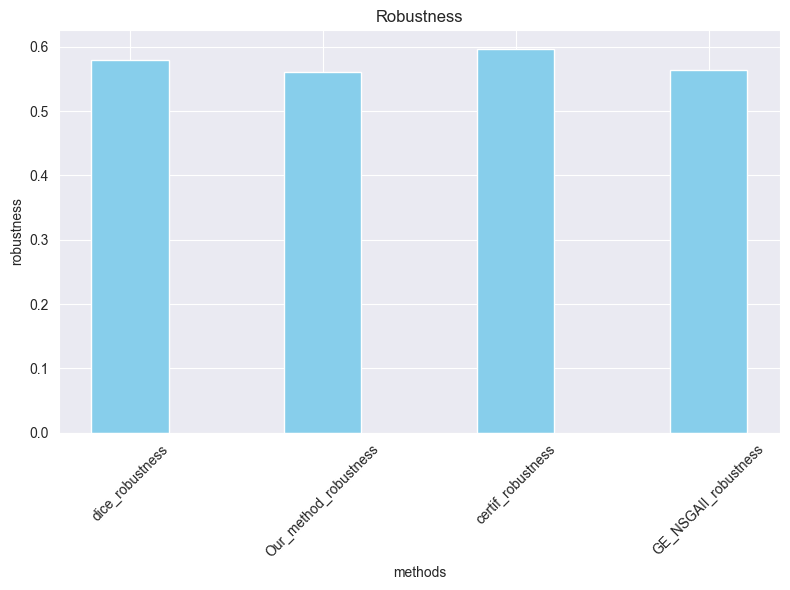

In [19]:
plot_bar_graph(output_dict, title="Robustness", xlabel="methods", ylabel="robustness")